In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from score_analysis import showbias
from score_analysis.showbias_plotting import (
    plot_multiple_thresholds,
    plot_single_threshold,
)

rng = np.random.default_rng()

## Create some toy data

In its simplest case, the showbias function assumes that you have a pandas dataframe with three columns:
- a `group` column that indicates group membership for every row, e.g. female and male values in a column called gender
- a `scores` column that contains the predicted scores (e.g. by a model) for
- a `labels` column that contains the ground truth using integers

Below we create a synthetic dataset that contains dogfido<b><sup>TM</sup></b> IDV data for different dog breeds

In [2]:
dog_breeds = ["German Shepherd", "Golden Retriever", "Bulldog", "Beagle"]
genders = ["male", "female"]
n = 1_000

df = pd.DataFrame(
    {
        "breed": rng.choice(dog_breeds, size=n),
        "gender": rng.choice(genders, size=n),
        "labels": rng.choice([0, 1], size=n),
        "scores": rng.uniform(0.0, 1.0, size=n),
    }
)

In [3]:
df.head()

,breed,gender,labels,scores
0,Beagle,male,0,0.576581
1,Beagle,male,1,0.878299
2,Bulldog,male,0,0.595094
3,Bulldog,male,1,0.896432
4,Golden Retriever,male,0,0.051532


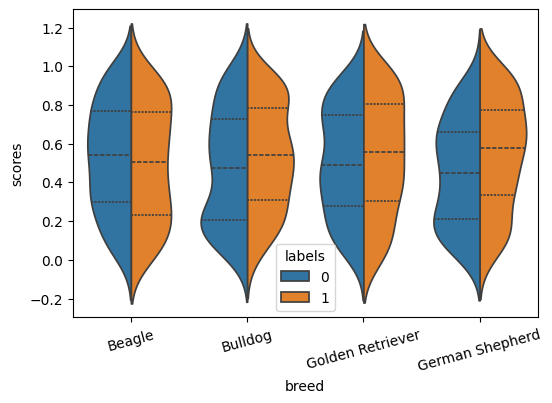

In [4]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="breed", y="scores", hue="labels", split=True, inner="quart")
plt.xticks(rotation=15)
plt.show()

## Showbias vanilla version

In [5]:
bias_frame = showbias(
    data=df,
    group_columns=["breed", "gender"],
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=[0.5],
)

In [6]:
bias_frame.values

0.5
breed            gender          
Beagle           female  0.485294
                 male    0.508197
Bulldog          female  0.415385
                 male    0.517241
German Shepherd  female  0.421875
                 male    0.412698
Golden Retriever female  0.487179
                 male    0.447761

## Passing several thresholds at once

In [7]:
bias_frame = showbias(
    data=df,
    group_columns=["breed", "gender"],
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=[0.3, 0.5, 0.7],
)
bias_frame.values

0.3       0.5       0.7
breed            gender                              
Beagle           female  0.294118  0.485294  0.720588
                 male    0.344262  0.508197  0.672131
Bulldog          female  0.230769  0.415385  0.676923
                 male    0.258621  0.517241  0.724138
German Shepherd  female  0.250000  0.421875  0.656250
                 male    0.190476  0.412698  0.634921
Golden Retriever female  0.256410  0.487179  0.666667
                 male    0.238806  0.447761  0.701493

## Normalizing metric

You can obtain metrics that are normalized to the metric measured across the entire dataset by passing the `normalize` argument, like so:

In [8]:
bias_frame = showbias(
    data=df,
    group_columns=["breed", "gender"],
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=[0.5],
    normalize="by_overall",
)
bias_frame.values

0.5
breed            gender          
Beagle           female  1.050802
                 male    1.100393
Bulldog          female  0.899428
                 male    1.119977
German Shepherd  female  0.913481
                 male    0.893611
Golden Retriever female  1.054885
                 male    0.969533

## What is a BiasFrame?

In [9]:
type(bias_frame)

score_analysis.showbias.BiasFrame

In [10]:
print(bias_frame)

BiasFrame(values=                              0.5
breed            gender          
Beagle           female  1.050802
                 male    1.100393
Bulldog          female  0.899428
                 male    1.119977
German Shepherd  female  0.913481
                 male    0.893611
Golden Retriever female  1.054885
                 male    0.969533, alpha=None, lower=None, upper=None)


In [11]:
type(bias_frame.values)

pandas.core.frame.DataFrame

## Confidence intervals

You can obtain confidence intervals by setting the `bootstrap_ci` to `True`:

In [12]:
bias_frame = showbias(
    data=df,
    group_columns=["breed", "gender"],
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=[0.5],
    bootstrap_ci=True,
)

In [13]:
bias_frame.values

0.5
breed            gender          
Beagle           female  0.485294
                 male    0.508197
Bulldog          female  0.415385
                 male    0.517241
German Shepherd  female  0.421875
                 male    0.412698
Golden Retriever female  0.487179
                 male    0.447761

In [14]:
bias_frame.lower

0.5
breed            gender          
Beagle           female  0.369863
                 male    0.380929
Bulldog          female  0.305775
                 male    0.389388
German Shepherd  female  0.310345
                 male    0.299797
Golden Retriever female  0.383381
                 male    0.328635

In [15]:
bias_frame.upper

0.5
breed            gender          
Beagle           female  0.592100
                 male    0.629512
Bulldog          female  0.550000
                 male    0.634615
German Shepherd  female  0.545086
                 male    0.533234
Golden Retriever female  0.600000
                 male    0.566667

In [16]:
print(bias_frame.to_markdown())

|                                | 0.5             |
|:-------------------------------|:----------------|
| ('Beagle', 'female')           | 0.485           |
|                                | (0.37 - 0.592)  |
| ('Beagle', 'male')             | 0.508           |
|                                | (0.381 - 0.63)  |
| ('Bulldog', 'female')          | 0.415           |
|                                | (0.306 - 0.55)  |
| ('Bulldog', 'male')            | 0.517           |
|                                | (0.389 - 0.635) |
| ('German Shepherd', 'female')  | 0.422           |
|                                | (0.31 - 0.545)  |
| ('German Shepherd', 'male')    | 0.413           |
|                                | (0.3 - 0.533)   |
| ('Golden Retriever', 'female') | 0.487           |
|                                | (0.383 - 0.6)   |
| ('Golden Retriever', 'male')   | 0.448           |
|                                | (0.329 - 0.567) |


## BiasFrame methods

### to_markdown()

In [17]:
bias_frame_md = bias_frame.to_markdown(
    reset_display_index=True, number_decimal_points=5
)
print(bias_frame_md)

| breed            | gender   | 0.5                 |
|:-----------------|:---------|:--------------------|
| Beagle           | female   | 0.48529             |
|                  |          | (0.36986 - 0.5921)  |
| Beagle           | male     | 0.5082              |
|                  |          | (0.38093 - 0.62951) |
| Bulldog          | female   | 0.41538             |
|                  |          | (0.30578 - 0.55)    |
| Bulldog          | male     | 0.51724             |
|                  |          | (0.38939 - 0.63462) |
| German Shepherd  | female   | 0.42188             |
|                  |          | (0.31034 - 0.54509) |
| German Shepherd  | male     | 0.4127              |
|                  |          | (0.2998 - 0.53323)  |
| Golden Retriever | female   | 0.48718             |
|                  |          | (0.38338 - 0.6)     |
| Golden Retriever | male     | 0.44776             |
|                  |          | (0.32863 - 0.56667) |


## Plotting functionality

### plot_single_threshold

In [18]:
dog_breeds = ["German Shepherd", "Golden Retriever", "Bulldog", "Beagle"]
n = 1_000

df = pd.DataFrame(
    {
        "breed": rng.choice(dog_breeds, size=n),
        "labels": rng.choice([0, 1], size=n),
        "scores": rng.uniform(0.0, 1.0, size=n),
    }
)

bias_frame = showbias(
    data=df,
    group_columns="breed",
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=[0.5],
    bootstrap_ci=True,
)

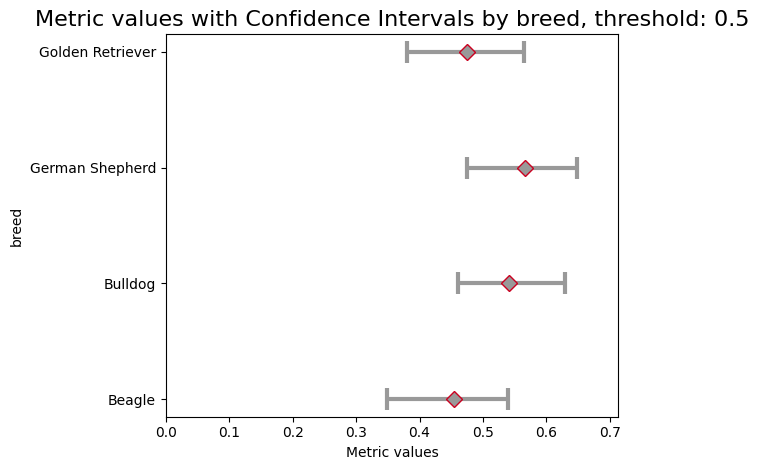

In [19]:
plot_single_threshold(bias_frame, threshold=0.5)

### plot_multiple_thresholds

In [20]:
bias_frame = showbias(
    data=df,
    group_columns="breed",
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=np.linspace(0.0, 1.0, 1000),
)

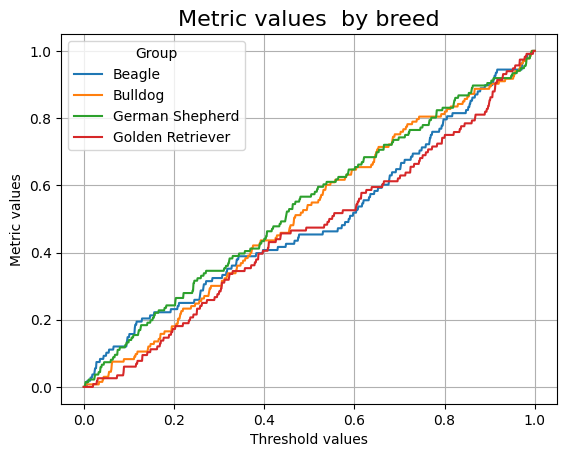

In [21]:
plot_multiple_thresholds(bias_frame)

## Available metrics

`showbias` supports all metrics that are supported by `score-analysis`.
Currently, you can pass any of the strings below to the metric argument in showbias:

Basic parameters:
- "tp" (true positive)
- "tn" (true negative)
- "fp" (false positive)
- "fn" (false negative)
- "p" (condition positive)
- "n" (condition negative)
- "top" (test outcome positive)
- "ton" (test outcome negative)
- "pop" (population counts)

Class metrics
- "tpr" (true positive rate)
- "tnr" (true negative rate)
- "fpr" (false positive rate)
- "fnr" (false negative rate)
- "topr" (test outcome positive rate)
- "tonr" (test outcome negative rate)
- "ppv" (positive predictive value)
- "npv" (negative predictive value)
- "fdr" (false discovery rate)
- "for_" (false omission rate)
- "class_accuracy" (class accuracy)
- "class_error_rate" (class_error_rate)

Overall metrics
- "accuracy" (Accuracy)
- "error_rate" (Error rate)